In [126]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import time
import xgboost as xgb
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter('ignore', UserWarning)

import gc
gc.enable()

# data load

In [127]:
#X = pd.read_csv('X.csv')
#y = pd.read_csv('y.csv')
data = pd.read_csv('feature_X.csv')
#del data['y'] 
#del data['ds'] 
#del data['trend3'] 
X = data[[x for x in data.columns if x != 'target']]
y = data['target']  
#data = pd.concat([X,y], axis=1)

In [128]:
X

,month_begin*shakeamp_2Day,month_begin*shake_2Day,lag_3day*shake_Lowess_2Day,lag_2day*shake_Lowess_2Day,shake_Lowess_2Day,lag_2day*shake_Lowess_1Day,lag_3day*shake_2Day,shakeamp_2Day,shake_Lowess_1Day,month_begin*shake_7Day,...,month_begin^2,shake_Lowess_1Day_quantile,lag_3day^2,kurt_3Day,shake_2Day_quantile,continuous_down5Day,shakeamp_2Day_quantile,lag_3day_quantile,month_begin,lag_2day*shakeamp_2Day
0,-0.012254,-0.0385,-0.199802,-0.199428,-0.063474,-0.103789,0.121190,0.012254,-0.033034,-0.1807,...,1,1,9.908645,-1.5,3,0,3,3,-1,0.0385
1,-0.007955,-0.0253,-0.103789,-0.105061,-0.033034,-0.062482,0.079490,0.007955,-0.019646,-0.1959,...,1,2,9.871536,-1.5,3,0,2,3,-1,0.0253
2,-0.029978,-0.0961,-0.062482,-0.062979,-0.019646,0.193459,0.305636,0.029978,0.060348,-0.2363,...,1,3,10.114944,-1.5,4,0,3,4,-1,0.0961
3,0.006330,0.0209,0.193459,0.199259,0.060348,0.071509,-0.066999,-0.006330,0.021658,-0.1056,...,1,2,10.276512,-1.5,2,0,2,4,-1,-0.0209
4,0.003322,0.0109,0.071509,0.071057,0.021658,-0.015859,-0.035990,-0.003322,-0.004834,-0.1222,...,1,2,10.901883,-1.5,2,0,2,4,-1,-0.0109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1203,0.012951,0.0140,-0.010216,-0.010179,-0.009416,-0.031297,-0.015190,-0.012951,-0.028952,-0.0300,...,1,1,1.177225,-1.5,2,0,1,0,-1,-0.0140
1204,0.001874,0.0020,-0.031297,-0.030892,-0.028952,-0.039123,-0.002162,-0.001874,-0.036666,-0.0150,...,1,1,1.168561,-1.5,2,0,2,0,-1,-0.0020
1205,-0.016901,-0.0180,-0.039123,-0.039049,-0.036666,-0.026157,0.019206,0.016901,-0.024561,-0.0110,...,1,2,1.138489,-1.5,2,0,3,0,-1,0.0180
1206,-0.028624,-0.0310,-0.026157,-0.026599,-0.024561,0.000369,0.033015,0.028624,0.000341,-0.0270,...,1,2,1.134225,-1.5,3,0,3,0,-1,0.0310


In [129]:
categorical_feats = [
    f for f in data.columns if data[f].dtype == 'object'
]

categorical_feats
for f_ in categorical_feats:
    data[f_], _ = pd.factorize(data[f_])
    # Set feature type as categorical
    data[f_] = data[f_].astype('category')

In [130]:
feature_name = [f for f in data if f not in ['target']]

# feature importance

In [131]:
importances = []
def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    train_features = [f for f in data if f not in ['target']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['target'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['target'].copy().sample(frac=1.0)
    dtrain = xgb.DMatrix(X, y)
    xgb_parms = { 
        'max_depth':6, 
        'learning_rate':0.001, 
        'subsample':0.7,
        'colsample_bytree':0.7, 
        'eval_metric':'logloss',
        'objective':'binary:logistic',
        'random_state':42
    }
    # Fit the model
    model = xgb.train(xgb_parms, 
            dtrain=dtrain) 
    # Get feature importances
    actual_imp_df = pd.DataFrame()
    actual_imp_df["feature"] = list(feature_name)
    actual_imp_df["importance_gain"] = 0
    actual_imp_df["importance_split"] = 0
    actual_imp_df['trn_score'] = 0
    
    dd = model.get_score(importance_type='gain')
    df = pd.DataFrame({'feature':dd.keys(),'importance_gain':dd.values()})
    for i in df['feature']:
        temp = df.loc[df['feature'] == i]['importance_gain'].values
        actual_imp_df.loc[actual_imp_df['feature'] == i,'importance_gain'] = temp
    dd = model.get_score(importance_type='weight')
    df = pd.DataFrame({'feature':dd.keys(),'importance_split':dd.values()})
    for i in df['feature']:
        temp = df.loc[df['feature'] == i]['importance_split'].values
        actual_imp_df.loc[actual_imp_df['feature'] == i,'importance_split'] = temp
    actual_imp_df['trn_score'] = roc_auc_score(y, model.predict(xgb.DMatrix(data[train_features])))
    return actual_imp_df

In [132]:
actual_imp_df = get_feature_importances(data=data, shuffle=False)

In [133]:
actual_imp_df.to_csv('actual_imp_df_xgboost.csv', index=False)

# Null Importances distribution

In [134]:
null_imp_df = pd.DataFrame()
nb_runs = 100
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=data, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with  100 of  100 (Spent   0.4 min)

In [135]:
null_imp_df.to_csv('null_imp_df_xgboost.csv', index=False)

# Display distribution examples

In [122]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values,label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())

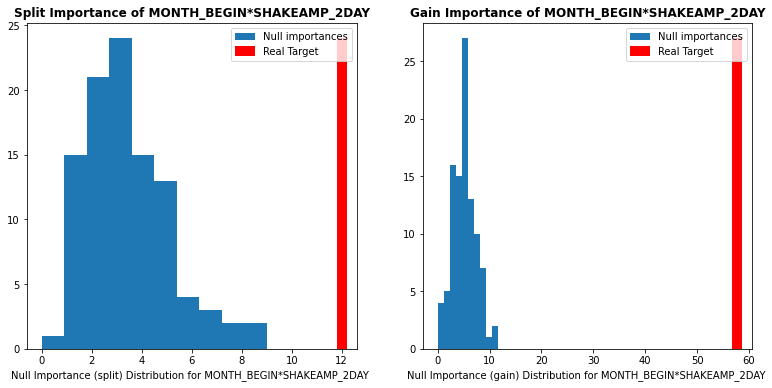

In [123]:
#无用特征
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='month_begin*shakeamp_2Day')

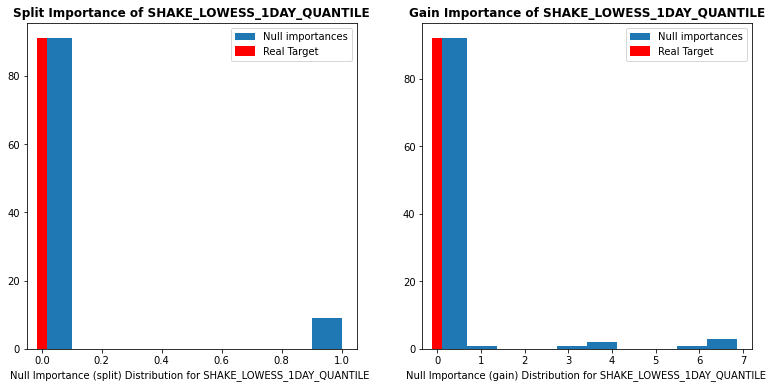

In [124]:
#优秀特征
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='shake_Lowess_1Day_quantile')

# Score features

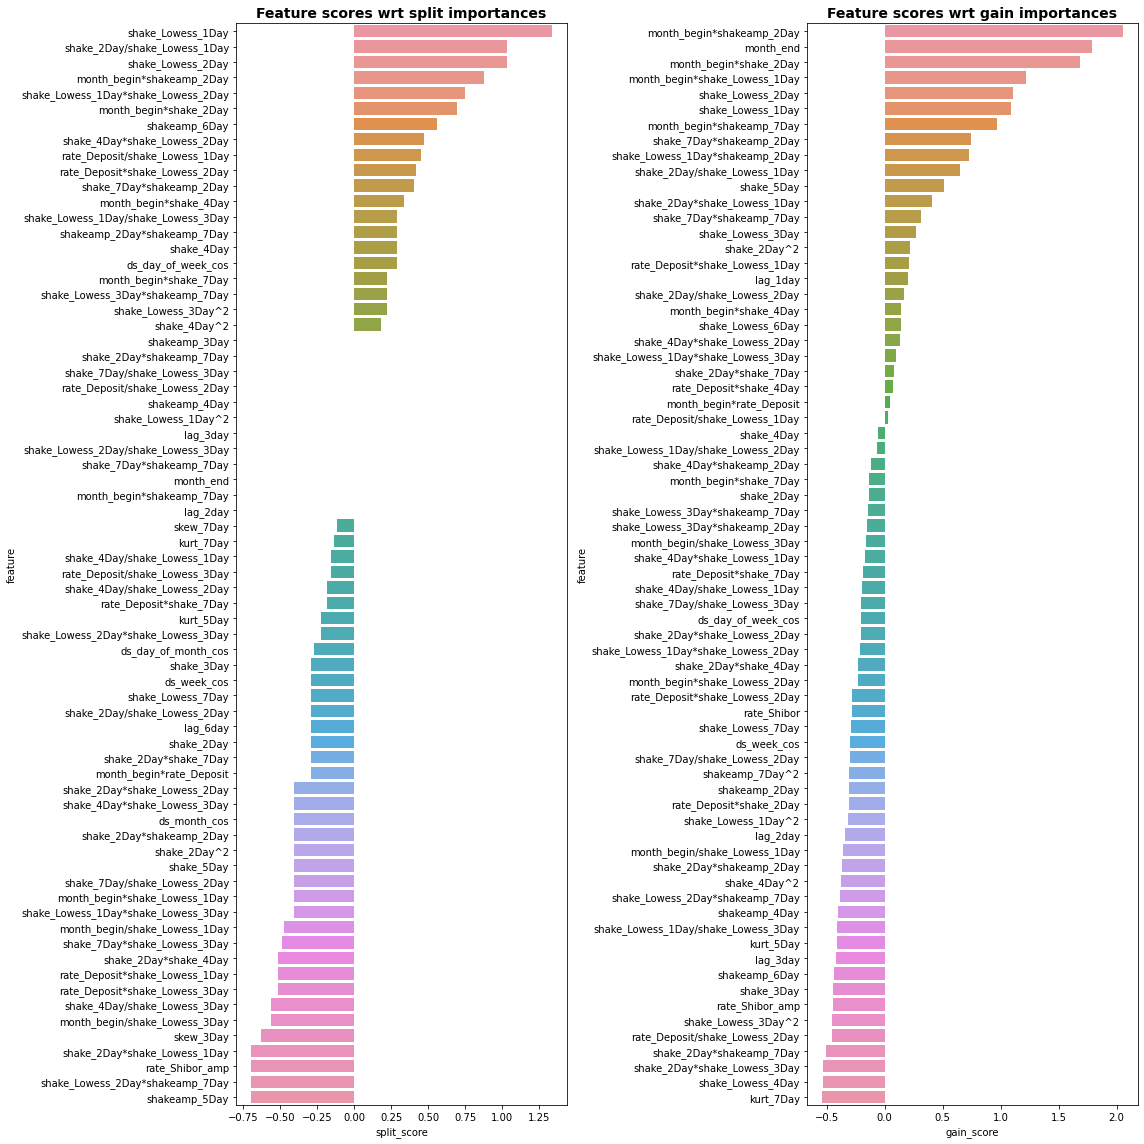

In [125]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

In [61]:
scores_df

,feature,split_score,gain_score
0,lag_1day,-6.931472e-01,-0.539258
1,lag_2day,-4.054651e-01,-0.258063
2,lag_3day,1.000000e-10,-0.370114
3,lag_4day,-4.054651e-01,-0.168633
4,lag_5day,-2.302585e+01,-23.025851
5,lag_6day,-8.109302e-01,-0.114228
6,lag_7day,-3.364722e-01,-0.454039
7,shake_2Day,2.682640e-01,1.347211
8,shakeamp_2Day,7.537718e-01,1.313542
9,shake_3Day,1.732717e-01,0.001543


In [62]:
null_imp_df.to_csv('null_importances_distribution_xgboost.csv')
actual_imp_df.to_csv('actual_importances_ditribution_xgboost.csv')

# Check the impact of removing uncorrelated features

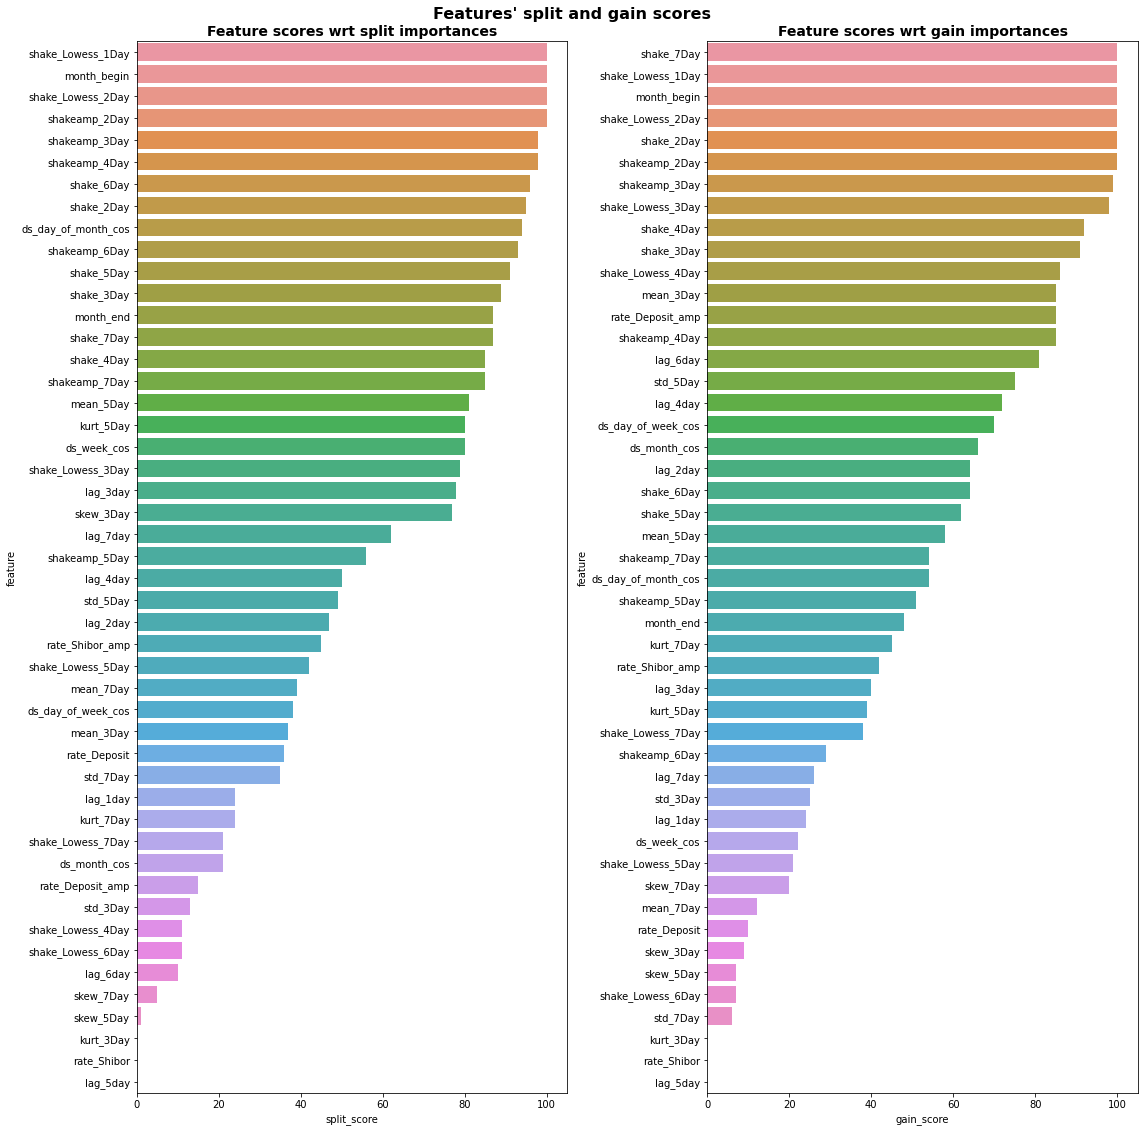

In [63]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.95)

In [64]:
corr_scores_df.sort_values(by="gain_score" , inplace=True, ascending=False) 

In [65]:
corr_scores_df.to_csv('corr_scores_df_xgboost.csv', index=False)

# score feature selection

In [82]:
def score_feature_selection(df=None, train_features=None, target=None):
    dtrain = xgb.DMatrix(df[train_features], target)
    xgb_parms = { 
        'max_depth':6, 
        'learning_rate':0.0001, 
        'subsample':0.6,
        'colsample_bytree':0.6, 
        'eval_metric':'logloss',
        'objective':'binary:logistic',
        'random_state':42
    }
    
    # Fit the model
    hist = xgb.cv(
        xgb_parms, 
        dtrain, 
        num_boost_round=50, 
        nfold=4, 
        metrics=['error'],
        early_stopping_rounds=5, 
        stratified=True, 
        seed=42
    )
    # Return the last mean / std values 
    return hist.tail(1)

# 全部特征

In [83]:
feature = feature_name
results = score_feature_selection(df = data, train_features=feature, target=data['target'])

In [84]:
results

,train-error-mean,train-error-std,test-error-mean,test-error-std
7,0.15011,0.007527,0.298013,0.029338


In [85]:
results

,train-error-mean,train-error-std,test-error-mean,test-error-std
7,0.15011,0.007527,0.298013,0.029338


# 删除全是0的特征

In [86]:
del_feats_name = corr_scores_df.loc[(corr_scores_df['split_score'] == 0) & (corr_scores_df['gain_score'] == 0)]['feature'].tolist()
train_features_name = [f for f in feature_name if f not in del_feats_name]
results = score_feature_selection(df = data, train_features=train_features_name, target=data['target'])

In [87]:
results

,train-error-mean,train-error-std,test-error-mean,test-error-std
14,0.139625,0.006826,0.290563,0.031793


# 删除有一个为0的特征

In [88]:
del_feats_name = corr_scores_df.loc[(corr_scores_df['split_score'] == 0) | (corr_scores_df['gain_score'] == 0)]['feature'].tolist()
train_features_name = [f for f in feature_name if f not in del_feats_name]
results = score_feature_selection(df = data, train_features=train_features_name, target=data['target'])

In [89]:
results

,train-error-mean,train-error-std,test-error-mean,test-error-std
14,0.139625,0.006826,0.290563,0.031793


# 只选前几个特征

In [90]:
del_feats_name = corr_scores_df.loc[(corr_scores_df['split_score'] == 0) | (corr_scores_df['gain_score'] == 0)]['feature'].tolist()
feats_name = [f for f in feature_name if f not in del_feats_name]

In [91]:
df = pd.DataFrame(feats_name,columns=['Name'])
df['gain'] = 0
for i in feats_name:
    temp = actual_imp_df.loc[actual_imp_df['feature'] == i]['importance_gain'].values
    #print(temp.tolist())
    df.loc[df['Name'] == i,'gain'] = temp

In [92]:
### 根据Gain的值对特征重要性进行降序排序
df.sort_values(by="gain" , inplace=True, ascending=False) 

In [93]:
for i in range (8,50):
    select_feats_name = df.head(i)['Name'].tolist()
    results = score_feature_selection(df = data,train_features=select_feats_name, target=data['target'])
    print('选择特征数量%d:' % i)
    print( results)

选择特征数量8:
    train-error-mean  train-error-std  test-error-mean  test-error-std
16          0.182119         0.003902          0.29553        0.015242
选择特征数量9:
    train-error-mean  train-error-std  test-error-mean  test-error-std
20          0.175773         0.001632         0.277318        0.027443
选择特征数量10:
    train-error-mean  train-error-std  test-error-mean  test-error-std
16          0.165839          0.00502         0.286424        0.014146
选择特征数量11:
    train-error-mean  train-error-std  test-error-mean  test-error-std
18          0.162528         0.003692         0.287252        0.018343
选择特征数量12:
   train-error-mean  train-error-std  test-error-mean  test-error-std
4          0.181567         0.006071         0.287252        0.034282
选择特征数量13:
   train-error-mean  train-error-std  test-error-mean  test-error-std
4          0.179912         0.002814         0.290563        0.030382
选择特征数量14:
   train-error-mean  train-error-std  test-error-mean  test-error-std
6          0.1

In [94]:
select_feats_name = df.head(9)['Name'].tolist()

In [95]:
select_feats_name

['shakeamp_2Day',
 'shake_2Day',
 'shake_Lowess_2Day',
 'month_begin',
 'shake_Lowess_1Day',
 'shake_7Day',
 'mean_3Day',
 'shakeamp_3Day',
 'shake_Lowess_3Day']

##### results

In [180]:
results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
13,0.893955,0.005377,0.772574,0.013745


# 使用至少有1个为100的特征

# 只使用全部是100 的特征

# 对两个都是100的提取出来并排序